## Final Project with Pokemon

### Import helpers

Run the following cells to import helper functions, files and libraries

In [134]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [135]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py

In [136]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [137]:
!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [138]:
! pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [139]:
import pandas as pd
import torch

from sklearn.model_selection import train_test_split


from data_utils import PCA, RandomForestClassifier, StandardScaler, SVC
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

In [140]:
from os import listdir, path
from random import choice

from image_utils import open_image, make_image, edges
from HW06_utils import HW06Utils
from data_utils import classification_error, display_confusion_matrix
from os import listdir, path
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader

from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

In [141]:
import torch

from os import listdir, path

from image_utils import make_image, open_image

from HW12_utils import HW12Utils, FaceDataset

## Image Classification

### Reading all the labeled files

Let's first read all of the files in the `data/images/classification/train` directory.

We are going to use the `Python` system function `listdir()` for listing files in a directory.

In [142]:
# Declare location of train files
TRAIN_PATH = "data/images/pokemon_train"

# List comprehension for getting all of the filenames that end in "jpg" inside the train directory
train_files = [f for f in listdir(TRAIN_PATH) if f.endswith("png")]

### Checking our list

Take a look at the `train_files` list.

In [143]:
# print the size of the train_files list here, along with some of its contents
print(len(train_files))
train_files[0]

16


'yanmega_gen.png'

### Reading the unlabeled files

Repeat the above steps to get the names of all of the files inside the `data/images/classification/test` directory.

In [144]:
# Fill out the values for these two variables

# Declare location of test files
TEST_PATH = "data/images/pokemon_test"

# Get all of the filenames that end in "jpg" inside the test directory
test_files = [f for f in listdir(TEST_PATH) if f.endswith("png")]

# Print the number of files inside the list and some of its contents
print(len(test_files))
test_files[0]

4


'yanma_gen.png'

### Iterating through the files

Iterate through all of the files in `train_files`, open them, and get the number of pixels for each image.

In order to analyze, plot and process our data later, let's keep track of the number of pixels and the name of the file in a list with the following format:

```py
file_info = [
  [value, filename],
  [value, filename],
  ...
]
```

`file_info` is a list of lists, where each inner list has two members, `value`, which is some numeric info about the image, and `filename`, which is the name of the file.

The `value` is the number of pixels in each image file.

We'll use the `Python` function `path.join()` to get the full path of the files inside our `train_files` list.

And then, just like in the previous homework, we can use the `plot_labels_vals()` function inside the `HW06Utils` class to plot the info we extract from our files.

We just have to call the function with a list of `[value, filename]` elements, and a title for our graph.

If the `filename` used contains information about the image label it will group values by those labels.


16


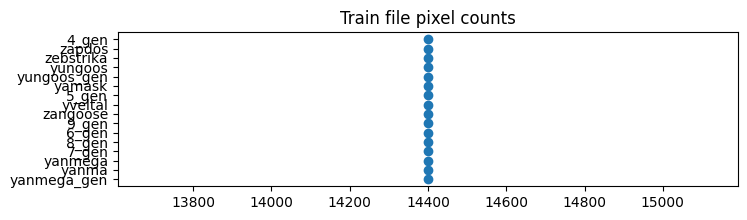

In [145]:
# list to keep info about image files
length_info_train = []

# iterate through all of the filenames inside the train files list
for fname in train_files:
  # this gets us the full location path for the filename
  fpath = path.join(TRAIN_PATH, fname)

  # open the file and read its pixels into an array
  mimg = open_image(fpath)
  mpxs = mimg.pixels

  # get value of interest (number of pixels in image)
  val = len(mpxs)

  # store the info using the format specified above
  length_info_train.append([ val, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(length_info_train))

# plot the (val, filename) pairs
HW06Utils.plot_labels_vals(length_info_train, "Train file pixel counts")

### Repeat for `test` files

Repeat the above process for the test files.

4


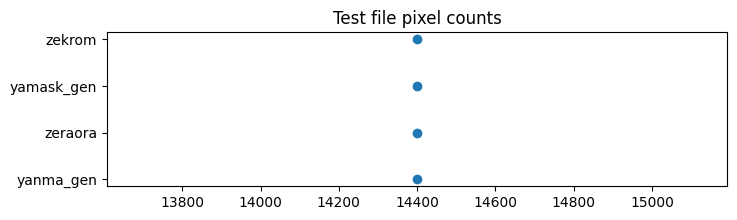

In [146]:
import matplotlib.pyplot as plt

# list to keep info about image files
length_info_test = []

for fname_test in test_files:
  # this gets us the full location path for the filename
  fpath_test = path.join(TEST_PATH, fname_test)

  # open the file and read its pixels into an array
  mimg_test = open_image(fpath_test)
  mpxs_test = mimg_test.pixels

  # get value of interest (number of pixels in image)
  val_test = len(mpxs_test)

  # store the info using the format specified above
  length_info_test.append([ val_test, fname_test ])

# check that we processed all files. This should be as long as the train_files list
print(len(length_info_test))

# plot the (val, filename) pairs
HW06Utils.plot_labels_vals(length_info_test, "Test file pixel counts")

### Looking at other(color) data

```py
pixel_ratio = HW06Utils.color_ratio(img, color, thold)
```

It takes an image, a color and a threshold value as inputs, and returns the ratio of detected pixels of that color relative to the total number of pixels in the image.

We want to use relative pixel counts or ratios to avoid any kind of bias due to image sizes. If we used absolute count, small areas of purple pixels in large images might overshadow large areas of purple pixels in smaller images.

16


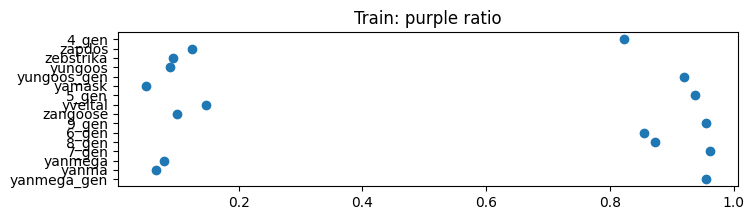

In [147]:
# list to keep info about image files
image_info_train = []

# color to filter: Orchid
keep_color = (186, 85, 211)

# iterate through all of the filenames inside the train files list
for fname in train_files:
  # this gets us the full location path for the filename
  fpath = path.join(TRAIN_PATH, fname)

  # open the file and read its pixels into an array
  mimg = open_image(fpath)

  # get value of interest (purple pixel ratio)
  val = HW06Utils.color_ratio(mimg, keep_color, 180)

  # store the info using the format specified above
  image_info_train.append([ val, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(image_info_train))

HW06Utils.plot_labels_vals(image_info_train, "Train: purple ratio")

### Create a model

Let's use the info in the graph and create a function that outputs the image label based on its purple pixel amount.

In [148]:
# function that takes an image and returns a label
def purple_ratio_classifier(img):
  keep_color = (186, 85, 211)
  purple_ratio = HW06Utils.color_ratio(img, keep_color, 180)
  if purple_ratio > 0.6:
    return "generated"
  else:
    return "original"

### Random classifier

We're also gonna create a random classifier to use as a baseline for comparisons later.

The random classifier just guesses a label randomly. Our model should do better than random guesses.

In [149]:
# random classifier to use for comparisons
def random_classifier(_):
  # the choice() function selects a random element from a list
  return choice(["generated","original" ])

### Run classification on `train` data

Let's iterate through all the train files again, and this time instead of saving the purple ratio value and the filename in the list, we'll save our calculated label and the filename.

```py
purple_ratio_predictions = [
  [label, filename],
  [label, filename],
  ...
]
```

We'll also keep track of classifications made by the `random_classifier`.

In [150]:
# list to keep info about predictions
purple_ratio_predictions_train = []

# list to keep info about random predictions
random_predictions_train = []

# iterate through all of the filenames inside the train files list
for fname in train_files:
  # this gets us the full location path for the filename
  fpath = path.join(TRAIN_PATH, fname)

  # open the image from the file
  mimg = open_image(fpath)

  # get prediction using model defined above
  prediction = purple_ratio_classifier(mimg)

  # get prediction using random classifier defined above
  random_prediction = random_classifier(mimg)

  # store the prediction and filename
  purple_ratio_predictions_train.append([ prediction, fname ])

  # store the random prediction and filename
  random_predictions_train.append([ random_prediction, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(purple_ratio_predictions_train))

# look at first couple of predictions just to check that our format is correct
print(purple_ratio_predictions_train[:3])

16
[['generated', 'yanmega_gen.png'], ['original', 'yanma.png'], ['original', 'yanmega.png']]


In [151]:
# list to keep info about predictions
purple_ratio_predictions_test = []

for fname in test_files:
  # this gets us the full location path for the filename
  fpath = path.join(TEST_PATH, fname)

  # open the image from the file
  mimg = open_image(fpath)

  # get prediction using model defined above
  prediction = purple_ratio_classifier(mimg)

  # store the prediction and filename
  purple_ratio_predictions_test.append([ prediction, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(purple_ratio_predictions_test))

# look at first couple of predictions just to check that our format is correct
print(purple_ratio_predictions_test[:3])

#print("Purple Classifier", HW06Utils.classification_accuracy(purple_ratio_predictions_test))

4
[['generated', 'yanma_gen.png'], ['original', 'zeraora.png'], ['generated', 'yamask_gen.png']]


## Random Forest (transparent origin images)

### Helper Function

In [152]:
# helper function to add lable
def add_label(fname):
    # Initialize the label
    if 'gen' in fname:  # Check if 'gen' is in the filename
        label = 1  # Assign 1 if 'gen' is found
    else:
        label = 0  # Assign 0 otherwise
    return label  # Return the label


In [153]:
import pandas as pd
import numpy as np


def classification_accuracy(train_files, train_predictions):

    # Ensure train_predictions is a DataFrame with exactly one column
    if not isinstance(train_predictions, pd.DataFrame) or train_predictions.shape[1] != 1:
        raise ValueError("train_predictions must be a DataFrame with a single column.")
    
    # Extract predictions as a flat list/array
    predictions = train_predictions.iloc[:, 0].tolist()

    # Check if train_files and predictions have the same length
    if len(train_files) != len(predictions):
        raise ValueError("The length of train_files and train_predictions must match.")

    # Generate true labels from the filenames
    true_labels = [1 if 'gen' in fname else 0 for fname in train_files]

    # Compare predictions with true labels
    correct_predictions = sum([pred == true for pred, true in zip(predictions, true_labels)])

    # Calculate accuracy as a percentage
    accuracy = (correct_predictions / len(train_files)) * 100

    return accuracy


In [154]:
# Group every 4 elements into sublists within the array
def group_pixels(pixel_array, group_size=4):
    grouped_pixels = np.array(pixel_array).reshape(-1, group_size)
    return grouped_pixels

In [155]:
#train test split for dataframe
def train_test_split(data, test_ratio=0.2, random_seed=None):

    # Set the random seed for reproducibility (optional)
    if random_seed is not None:
        np.random.seed(random_seed)

    # Convert to a NumPy array for easier manipulation if it's a list
    if isinstance(data, list):
        data = np.array(data)

    # Shuffle the indices of the data
    indices = np.arange(len(data))
    np.random.shuffle(indices)

    # Compute the split point
    split_point = int(len(data) * (1 - test_ratio))

    # Split the data into training and testing sets
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]

    if isinstance(data, pd.DataFrame):  # For DataFrame input
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]
    else:  # For lists or NumPy arrays
        train_data = data[train_indices]
        test_data = data[test_indices]

    return train_data, test_data

In [156]:
import random

def train_test_split_combined(data_combined, test_size=0.2):

    # Shuffle the data
    random.shuffle(data_combined)
    
    # Calculate the split index
    split_index = int(len(data_combined) * (1 - test_size))
    
    # Split into train and test sets
    train_data = data_combined[:split_index]
    test_data = data_combined[split_index:]
    
    # Convert into dictionaries
    train = {'pixels': [], 'labels': [], 'file_names': []}
    test = {'pixels': [], 'labels': [], 'file_names': []}
    
    # Populate the train and test dictionaries
    for pixels, label, file_name in train_data:
        train['pixels'].append(pixels)
        train['labels'].append(label)
        train['file_names'].append(file_name)
    
    for pixels, label, file_name in test_data:
        test['pixels'].append(pixels)
        test['labels'].append(label)
        test['file_names'].append(file_name)
    
    return train, test


### Train Dataset

### Template for black and white image

In [157]:
pixel_data = []
label_data = []

for fname in train_files:
  label = add_label(fname)
  img = open_image(path.join("./data/images/pokemon_train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [158]:
pixel_data[0]

[(173, 173, 173, 255),
 (172, 172, 172, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (169, 169, 169, 255),
 (169, 169, 169, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170,

### Color Images

In [159]:
import numpy as np

In [160]:
pixel_data = []
label_data = []

for fname in train_files:
  label = add_label(fname)
  img = open_image(path.join("./data/images/pokemon_train", fname))
 # Convert the pixel data to a NumPy array
  pixel_array = np.array(img.pixels)
    
    # Flatten the NumPy array
  flattened_pixels = pixel_array.flatten()
    
  pixel_data.append(flattened_pixels)
  label_data.append(label)

In [161]:
pixel_data[0]

array([173, 173, 173, ..., 171, 171, 255], shape=(57600,))

### Show Color Image

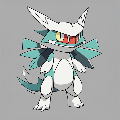

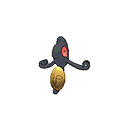

In [162]:

# Group the pixel data for display
image_0 = group_pixels(pixel_data[0], group_size=4)
image_10 = group_pixels(pixel_data[10], group_size=4)

# Display the grouped pixel data
display(make_image(image_0, width=120))
display(make_image(image_10, width=120))


### Make Pixels into DataFrame

In [163]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

In [164]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,label
0,173,173,173,255,172,172,172,255,171,171,...,255,172,172,172,255,171,171,171,255,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,211,213,214,255,210,212,213,255,210,211,...,255,209,210,212,255,209,210,212,255,1
4,186,186,186,255,185,185,185,255,185,185,...,255,185,185,185,255,185,185,185,255,1


### For Test

In [165]:
test_pixel_data = []

# Flatten pixel data for each image
for fname in test_files:
    img = open_image(path.join("./data/images/pokemon_test", fname))
    # Flatten the image pixels into a 1D array
    flattened_pixels = np.array(img.pixels).flatten()
    test_pixel_data.append(flattened_pixels)

# Load into DataFrame
test_df = pd.DataFrame(test_pixel_data)

In [166]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
0,218,218,218,255,218,218,218,255,216,216,...,215,255,213,215,215,255,213,215,215,255
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,214,214,214,255,214,214,214,255,214,214,...,213,255,213,213,213,255,213,213,213,255
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Random Forest Classifier Model

In [167]:
# split input and output features
NUM_FEATURES = 5
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

In [168]:
out_features

0     1
1     0
2     0
3     1
4     1
5     1
6     1
7     0
8     0
9     1
10    0
11    1
12    0
13    0
14    0
15    1
Name: label, dtype: int64

In [169]:
train_features

,0,1,2,3,4
0,173,173,173,255,172
1,0,0,0,0,0
2,0,0,0,0,0
3,211,213,214,255,210
4,186,186,186,255,185
5,218,218,218,255,217
6,212,214,213,255,209
7,0,0,0,0,0
8,0,0,0,0,0
9,218,218,218,255,217


In [170]:
# TODO: create a brand new classifier
image_model = RandomForestClassifier()
# TODO: fit the model
image_model.fit(train_features, out_features)
# TODO: run predictions
train_predictions = image_model.predict(train_features)

In [171]:
classification_accuracy(train_files, train_predictions)

100.0

In [172]:
type(train_predictions)

pandas.core.frame.DataFrame

In [173]:
# TODO: run predictions on test data
test_predictions = image_model.predict(test_features)
# TODO: measure classification accuracy
classification_accuracy(test_files, test_predictions)

100.0

### PCA from HW10

### For the Generated Images

In [200]:
TRAIN_GEN_PATH = "data/images/pokemon_generated"

# Get all of the filenames that end in "jpg" inside the test directory
train_gen_files = [f for f in listdir(TRAIN_GEN_PATH) if f.endswith("png")]

In [202]:
# Lists to store the data
pixel_data = []
label_data = []
file_names = []

for fname in train_gen_files:
    # Get the label for the image
    label = add_label(fname)
    
    # Load the image
    img = open_image(path.join("./data/images/pokemon_generated", fname))
    
    # Convert the pixel data to a NumPy array and flatten it
    pixel_array = np.array(img.pixels).flatten()
    
    # Append the data to the respective lists
    pixel_data.append(pixel_array.tolist())  # Convert flattened NumPy array to list
    label_data.append(label)
    file_names.append(fname)

# Create the DataFrame with three columns

train_gen_df = pd.DataFrame({
    "pixels": pixel_data,
    "label": label_data,
    "fname": file_names
})

# Display the first few rows of the DataFrame
print(train_gen_df.head())


                                              pixels  label            fname
0  [191, 191, 191, 255, 191, 191, 191, 255, 191, ...      1     new1_gen.png
1  [173, 173, 173, 255, 172, 172, 172, 255, 171, ...      1  yanmega_gen.png
2  [214, 214, 214, 255, 213, 213, 213, 255, 213, ...      1     new2_gen.png
3  [218, 218, 218, 255, 218, 218, 218, 255, 216, ...      1    yanma_gen.png
4  [67, 65, 64, 255, 66, 65, 63, 255, 64, 62, 62,...      1     new8_gen.png


In [203]:
# Combine pixel_data, label_data, and file_names into a single list
train_gen = list(zip(pixel_data, label_data, file_names))

# Example: Display the first combined item
print(train_gen[0])  # Output: (pixels_list, label, filename)


([191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 192, 192, 192, 255, 192, 192, 192, 255, 192, 192, 192, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 190, 190, 190, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 190, 190, 190, 255, 190, 190, 190, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 190, 190, 190, 255, 190, 190, 190, 255, 190, 190, 190, 255, 190, 190, 190, 255, 190, 190, 190, 255, 190, 190, 190, 255, 190, 190, 190, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255, 191, 191, 191, 255

In [204]:
train, test = train_test_split_combined(train_gen,0.5 )

In [205]:
face_pca = PCA(n_components=8)
train_df = face_pca.fit_transform(train["pixels"])

In [207]:
print("explained variance:", face_pca.explained_variance())

explained variance: 0.9409639964977818


In [208]:
type(train_df)

pandas.core.frame.DataFrame

label: 1 
from: yanma_gen.png


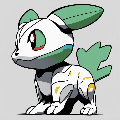

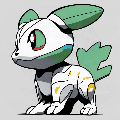

label: 1 
from: new4_gen.png


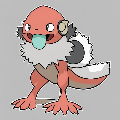

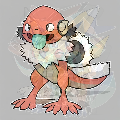

label: 1 
from: new10_gen.png


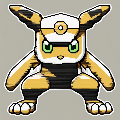

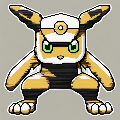

label: 1 
from: 8_gen.png


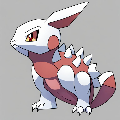

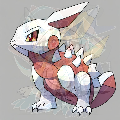

label: 1 
from: new9_gen.png


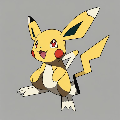

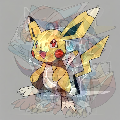

In [209]:
# TODO: change this label to your label to see how
#       your images are being encoded
awesome_label = "1"


# this filters the DataFrame by our label
awesome_df = train_df

# reconstruct all images
pca_pixels = face_pca.inverse_transform(awesome_df)

# associate the original indexes with the reconstructed pca pixels
idx_pca = zip(awesome_df.index, pca_pixels.values)

# iterate through indexes and pca pixels
for img_idx, img_pca in list(idx_pca)[:5]:
  print("label:", awesome_label,
        "\nfrom:", train["file_names"][img_idx])
  # Group the pixel data for display
  image_0 = group_pixels(train["pixels"][img_idx], group_size=4)
  image_10 = group_pixels(img_pca, group_size=4)

# Display the grouped pixel data
  display(make_image(image_0, width=120))
  display(make_image(image_10, width=120))

### For the Original Images

In [221]:
TRAIN_ORI_PATH = "data/images/pokemon_origin"

# Get all of the filenames that end in "jpg" inside the test directory
train_ori_files = [f for f in listdir(TRAIN_ORI_PATH) if f.endswith("png")]

In [222]:
# Lists to store the data
pixel_data = []
label_data = []
file_names = []

for fname in train_ori_files:
    # Get the label for the image
    label = add_label(fname)
    
    # Load the image
    img = open_image(path.join("./data/images/pokemon_origin", fname))
    
    # Convert the pixel data to a NumPy array and flatten it
    pixel_array = np.array(img.pixels).flatten()
    
    # Append the data to the respective lists
    pixel_data.append(pixel_array.tolist())  # Convert flattened NumPy array to list
    label_data.append(label)
    file_names.append(fname)

# Create the DataFrame with three columns

train_ori_df = pd.DataFrame({
    "pixels": pixel_data,
    "label": label_data,
    "fname": file_names
})

# Display the first few rows of the DataFrame
print(train_ori_df.head())


                                              pixels  label           fname
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0       zorua.png
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0       yanma.png
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0     yanmega.png
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0    virizion.png
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0  zygarde-50.png


In [223]:
# Combine pixel_data, label_data, and file_names into a single list
train_ori = list(zip(pixel_data, label_data, file_names))

# Example: Display the first combined item
print(train_ori[0])  # Output: (pixels_list, label, filename)


([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [224]:
train, test = train_test_split_combined(train_ori,0.5 )

In [225]:
f_pca = PCA(n_components=8)
train_df = f_pca.fit_transform(train["pixels"])

In [227]:
print("explained variance:", f_pca.explained_variance())

explained variance: 0.9681957623121302


label: 0 
from: zygarde-50.png


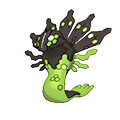

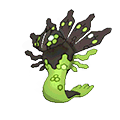

label: 0 
from: zangoose.png


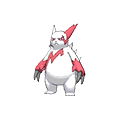

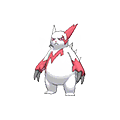

label: 0 
from: vileplume.png


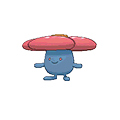

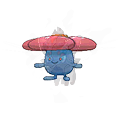

label: 0 
from: zeraora.png


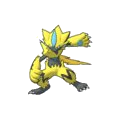

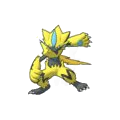

label: 0 
from: yamask.png


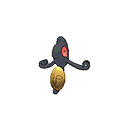

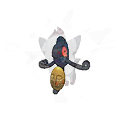

In [228]:
# TODO: change this label to your label to see how
#       your images are being encoded
awesome_label = "0"


# this filters the DataFrame by our label
awesome_df = train_df

# reconstruct all images
pca_pixels = f_pca.inverse_transform(awesome_df)

# associate the original indexes with the reconstructed pca pixels
idx_pca = zip(awesome_df.index, pca_pixels.values)

# iterate through indexes and pca pixels
for img_idx, img_pca in list(idx_pca)[:5]:
  print("label:", awesome_label,
        "\nfrom:", train["file_names"][img_idx])
  # Group the pixel data for display
  image_0 = group_pixels(train["pixels"][img_idx], group_size=4)
  image_10 = group_pixels(img_pca, group_size=4)

# Display the grouped pixel data
  display(make_image(image_0, width=120))
  display(make_image(image_10, width=120))

## Interpretation

I first attempted to manually classify the generated images and the original images based on the use of the purple pixel color and the result works really well. Based on this observation, I decided to further test the performance of a pre-built model, such as a Random Forest classifier, to see how it performs. One possible reason why the Random Forest classifier worked so well is that the original images are PNG files without a background, whereas the generated images include a background.

Another reason could be the differences in how the color purple is used in the generated and original images, as indicated by a subsequent PCA analysis on both sets of images. For the PCA on the generated images, those with colors closer to purple tend to produce blurrier results, revealing additional layers with purple tones in the background. In contrast, for images like Pikachu that contain fewer red or purple tones, the results appear clearer compared to those with more red or purple tones.

For the original images, Pokémon primarily constructed with red tones remain clear even after applying PCA.

## Random Forest Classification with Background for Both Generated and Original Pokemon Images

### Load & Show Train Images

In [189]:
# Declare location of train files
TRAIN_PATH = "data/images/pokemon_train_white"

# List comprehension for getting all of the filenames that end in "png" inside the train directory
train_files = [f for f in listdir(TRAIN_PATH) if f.endswith("png")]

In [190]:
pixel_data = []
label_data = []

for fname in train_files:
  label = add_label(fname)
  img = open_image(path.join("./data/images/pokemon_train_white", fname))
 # Convert the pixel data to a NumPy array
  pixel_array = np.array(img.pixels)
    
    # Flatten the NumPy array
  flattened_pixels = pixel_array.flatten()
    
  pixel_data.append(flattened_pixels)
  label_data.append(label)

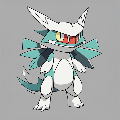

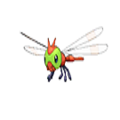

In [191]:

# Group the pixel data for display
image_0 = group_pixels(pixel_data[0], group_size=4)
image_10 = group_pixels(pixel_data[10], group_size=4)

# Display the grouped pixel data
display(make_image(image_0, width=120))
display(make_image(image_10, width=120))

### Make Pixels into DataFrame

In [192]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

In [193]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,label
0,173,173,173,255,172,172,172,255,171,171,...,255,172,172,172,255,171,171,171,255,1
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,211,213,214,255,210,212,213,255,210,211,...,255,209,210,212,255,209,210,212,255,1


### For Test Dataset

In [194]:
# Declare location of test files
TRAIN_PATH = "data/images/pokemon_test_white"

# List comprehension for getting all of the filenames that end in "png" inside the train directory
test_files = [f for f in listdir(TRAIN_PATH) if f.endswith("png")]

In [195]:
test_pixel_data = []

# Flatten pixel data for each image
for fname in test_files:
    img = open_image(path.join("./data/images/pokemon_test_white", fname))
    # Flatten the image pixels into a 1D array
    flattened_pixels = np.array(img.pixels).flatten()
    test_pixel_data.append(flattened_pixels)

# Load into DataFrame
test_df = pd.DataFrame(test_pixel_data)

### Random Forest Classifier Model

In [196]:
# split input and output features
NUM_FEATURES = 5
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

In [197]:
# TODO: create a brand new classifier
image_model = RandomForestClassifier()
# TODO: fit the model
image_model.fit(train_features, out_features)
# TODO: run predictions
train_predictions = image_model.predict(train_features)

In [198]:
classification_accuracy(train_files, train_predictions)

100.0

In [199]:
# TODO: run predictions on test data
test_predictions = image_model.predict(test_features)
# TODO: measure classification accuracy
classification_accuracy(test_files, test_predictions)

100.0

## Comments

The model still works well when the original image change from the transparent background into the white one as the generated files. Thus, I do not think the background is the reason that the classifier works so well. In contrast, according to the result of pca and the manual classifier I remain to the assumption that this is because the original images and the generated images use the color purple differently. The following session, I would use HW12 as a template to try the tensor to see if that works.

## Neural Network and PCA

### Merge the generated and origin folders ther to get a new folder (Only use once to create the folder)

In [ ]:
# import os
# import shutil

# # Paths to the original folders and the new folder
# folder_a = "data/images/pokemon_generated"
# folder_b =  "data/images/pokemon_origin"
# new_folder ="data/images/pokemon_origin_generate"

# # Create the new folder if it does not exist

# if not os.path.exists(new_folder):
#     os.makedirs(new_folder)

# # Function to copy files from a folder to the new folder
# def copy_files_to_new_folder(source_folder, destination_folder):
#     for filename in os.listdir(source_folder):
#         # Full path of the current file
#         source_file = os.path.join(source_folder, filename)
#         destination_file = os.path.join(destination_folder, filename)
        
#         # Check if it's a file and not a subfolder
#         if os.path.isfile(source_file):
#             # If the file already exists, you can decide how to handle it (skip, rename, etc.)
#             if not os.path.exists(destination_file):
#                 shutil.copy(source_file, destination_folder)
#             else:
#                 # Optional: rename file to avoid overwriting
#                 base, extension = os.path.splitext(filename)
#                 new_filename = base + "_copy" + extension
#                 destination_file = os.path.join(destination_folder, new_filename)
#                 shutil.copy(source_file, destination_file)

# # Copy files from Folder A and Folder B to the new folder
# copy_files_to_new_folder(folder_a, new_folder)
# copy_files_to_new_folder(folder_b, new_folder)

# print("Files copied successfully.")


### Get Pixel Dataframe with Labels

In [122]:
TRAIN_NN_PATH="data/images/pokemon_origin_generate"

# Get all of the filenames that end in "jpg" inside the test directory
train_ori_files = [f for f in listdir(TRAIN_NN_PATH) if f.endswith("png")]

In [123]:
# Lists to store the data
pixel_data = []
label_data = []
file_names = []

for fname in train_ori_files:
    # Get the label for the image
    label = add_label(fname)
    
    # Load the image
    img = open_image(path.join("./data/images/pokemon_origin_generate",fname))
    
    # Convert the pixel data to a NumPy array and flatten it
    pixel_array = np.array(img.pixels).flatten()
    
    # Append the data to the respective lists
    pixel_data.append(pixel_array.tolist())  # Convert flattened NumPy array to list
    label_data.append(label)
    file_names.append(fname)

# Create the DataFrame with three columns

train_ori_df = pd.DataFrame({
    "pixels": pixel_data,
    "label": label_data,
    "fname": file_names
})

# Display the first few rows of the DataFrame
print(train_ori_df.head())


                                              pixels  label            fname
0  [191, 191, 191, 255, 191, 191, 191, 255, 191, ...      1     new1_gen.png
1  [173, 173, 173, 255, 172, 172, 172, 255, 171, ...      1  yanmega_gen.png
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0        zorua.png
3  [214, 214, 214, 255, 213, 213, 213, 255, 213, ...      1     new2_gen.png
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0        yanma.png


### Split and into Tensor

In [124]:
# Combine pixel_data, label_data, and file_names into a single list
train_gen = list(zip(pixel_data, label_data, file_names))

In [125]:
train, test = train_test_split_combined(train_gen,0.5 )

In [126]:


x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

len(x_train), len(x_test)

(20, 20)

### Batches

In [127]:
train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128, shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=128)

### Build the Modle and Train

In [128]:
# TODO: Create the model, optimizer and loss function objects
model = nn.Linear(x_train.shape[1], len(y_train.unique()))

learning_rate = 1e-8
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [129]:
# TODO: iterate epochs
for e in range(28):
  # TODO: iterate batches
  for imgs, labels in train_dataloader:
    # TODO: predict
    labels_pred = model(imgs)
    # TODO: measure loss
    loss = loss_fn(labels_pred, labels)
    # TODO: compute gradient and step optimizer
    optim.zero_grad()
    loss.backward()
    optim.step()
    # TODO: show progress
  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 0.0671
Epoch: 7 loss: 3.3420
Epoch: 11 loss: 4.1531
Epoch: 15 loss: 2.3872
Epoch: 19 loss: 0.7270
Epoch: 23 loss: 0.0312
Epoch: 27 loss: 0.0000


### Evaluate

In [130]:
def get_labels(model, dataloader):
  model.eval()
  with torch.no_grad():
    data_labels = []
    pred_labels = []
    for imgs, labels in dataloader:
      labels_pred = model(imgs).argmax(dim=1)
      data_labels += [l.item() for l in labels]
      pred_labels += [l.item() for l in labels_pred]
    return data_labels, pred_labels

In [131]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

In [132]:
classification_error(train_labels,train_predictions)

0.0

In [133]:
classification_error(test_labels,test_predictions)

0.09999999999999998

### Comments

The NN also works really well. I assume this is because of the size of data. However, the classification error for the train and the test are almost the same, which is really interesting.